In [1]:
import os
import numpy as np
import jax

shape_counts = {}
folder_path = 'attention_outputs/xcl1'

for fname in os.listdir(folder_path):
    if fname.endswith('.npy'):
        arr = np.load(os.path.join(folder_path, fname))
        shape = arr.shape
        shape_counts[shape] = shape_counts.get(shape, 0) + 1

print("Unique shapes found:")
for shape, count in shape_counts.items():
    print(f"{shape}: {count} files")

Unique shapes found:
(69, 4, 69, 69): 104 files


In [3]:
arr = np.load('attention_outputs/xcl1/model_1_recycle_0_extra_msa_evoformer_loop_1_global_index_1.npy')
arr[0]


array([[[b'\x87\x40', b'\xD0\x40', b'\xCE\x40', ..., b'\x48\x40',
         b'\x4C\x40', b'\x5D\x40'],
        [b'\x8D\x40', b'\xB2\x40', b'\xD7\x40', ..., b'\x28\x40',
         b'\x1B\x40', b'\x32\x40'],
        [b'\x8A\x40', b'\xD1\x40', b'\xD0\x40', ..., b'\x32\x40',
         b'\x31\x40', b'\x48\x40'],
        ...,
        [b'\x16\x40', b'\x78\x40', b'\x7A\x40', ..., b'\x1E\x40',
         b'\x4E\x40', b'\x58\x40'],
        [b'\x14\x40', b'\x74\x40', b'\x7A\x40', ..., b'\x3B\x40',
         b'\x1F\x40', b'\x5F\x40'],
        [b'\x1F\x40', b'\x74\x40', b'\x80\x40', ..., b'\x36\x40',
         b'\x44\x40', b'\x28\x40']],

       [[b'\x56\x40', b'\x88\x40', b'\x89\x40', ..., b'\x54\x40',
         b'\x4A\x40', b'\x49\x40'],
        [b'\x78\x40', b'\xC7\x40', b'\xC7\x40', ..., b'\x8A\x40',
         b'\x89\x40', b'\x7E\x40'],
        [b'\x83\x40', b'\xC4\x40', b'\xB2\x40', ..., b'\x80\x40',
         b'\x7B\x40', b'\x6F\x40'],
        ...,
        [b'\x27\x40', b'\x82\x40', b'\x90\x40', ..., b

In [4]:
folder_path_1 = 'ColabFold/anc2f-logits'
n = 65

# Extract file roots and sort numerically
file_list = [fname for fname in os.listdir(folder_path_1) if fname.endswith('.npy')]
file_roots = sorted(file_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))

heads_n_4_n_n = []
heads_n_8_1_1 = []
heads_1_8_n_n = []

for fname in file_roots:
    arr1 = np.load(os.path.join(folder_path_1, fname))
    arr1 = arr1.view(dtype=np.float16)
    arr1 = jax.nn.softmax(arr1)

    if arr1.shape == (n, 4, n, n):
        heads_n_4_n_n.append(arr1)
    elif arr1.shape == (n, 8, 1, 1):
        heads_n_8_1_1.append(arr1)
    elif arr1.shape == (1, 8, n, n):
        heads_1_8_n_n.append(arr1)

In [5]:
attention_spectrum = []

for i in range(len(heads_n_4_n_n)):
    attn = np.sum(heads_n_4_n_n[i], axis=(0, 1, 2))
    attention_spectrum.append(attn)

attention_spectrum = np.array(attention_spectrum)

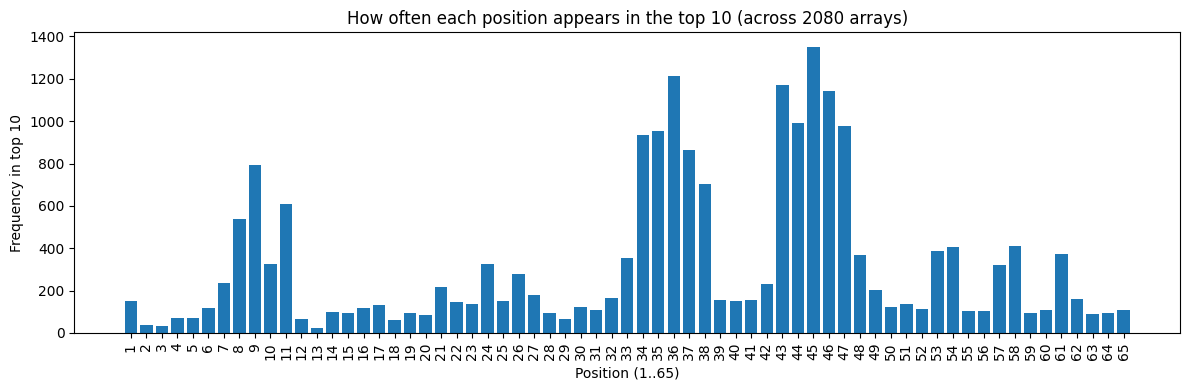

In [6]:
import matplotlib.pyplot as plt

# set top_k to the number of top entries you want to count (change as needed)
top_k = 10

num_positions = attention_spectrum.shape[1]  # 65
counts = np.zeros(num_positions, dtype=int)

for row in attention_spectrum:
    # indices of the top_k largest values in the row
    if top_k >= num_positions:
        top_idx = np.arange(num_positions)
    else:
        top_idx = np.argpartition(row, -top_k)[-top_k:]
    counts[top_idx] += 1

# Plot counts (x: 1..65, y: frequency)
x = np.arange(1, num_positions + 1)
plt.figure(figsize=(12, 4))
plt.bar(x, counts)
plt.xlabel(f'Position (1..{num_positions})')
plt.ylabel(f'Frequency in top {top_k}')
plt.title(f'How often each position appears in the top {top_k} (across {attention_spectrum.shape[0]} arrays)')
plt.xticks(x, rotation=90)
plt.tight_layout()
plt.show()

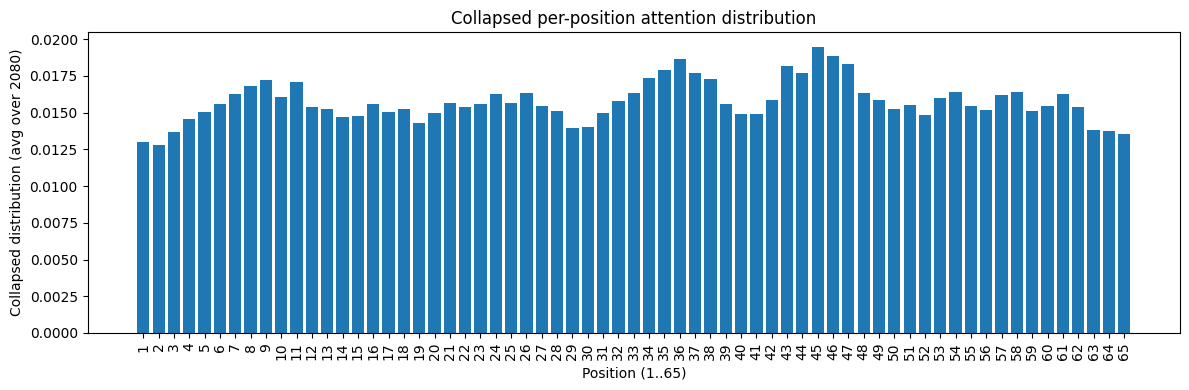

In [8]:
normalized_distributions = attention_spectrum / (65 * 65 * 4)
collapsed_distributions = (np.sum(normalized_distributions, axis=0) / 2080)

x = np.arange(1, collapsed_distributions.size + 1)
plt.figure(figsize=(12, 4))
plt.bar(x, collapsed_distributions)
plt.xlabel(f'Position (1..{collapsed_distributions.size})')
plt.ylabel('Collapsed distribution (avg over 2080)')
plt.title('Collapsed per-position attention distribution')
plt.xticks(x, rotation=90)
plt.tight_layout()
plt.show()

In [11]:
mat = np.zeros((65, 65))

for q in range(len(heads_n_4_n_n)):
    mat += np.outer(normalized_distributions[q], normalized_distributions[q])
            
eigvals, eigvecs = np.linalg.eigh(mat)
top_idx = np.argmax(eigvals)
top_eigvec = eigvecs[:, -1]
top_eigvec = top_eigvec / np.linalg.norm(top_eigvec)

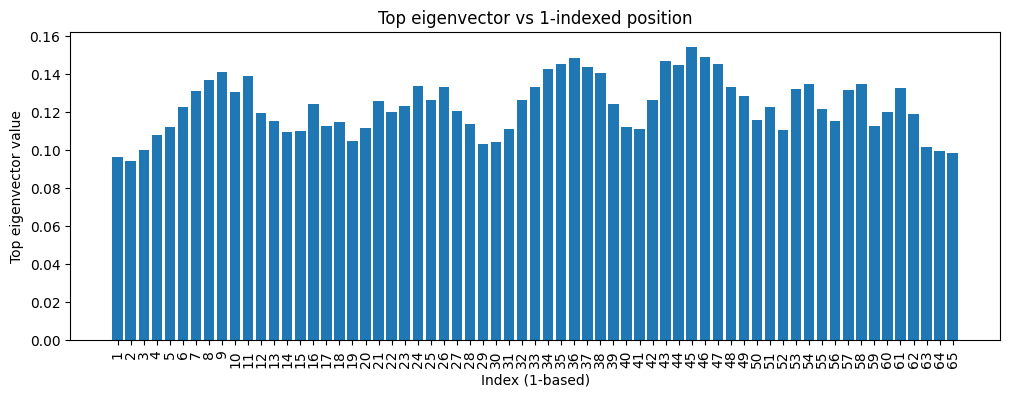

In [12]:
x = np.arange(1, top_eigvec.size + 1)  # 1-indexed positions
plt.figure(figsize=(12, 4))
plt.bar(x, top_eigvec)
plt.xlabel('Index (1-based)')
plt.ylabel('Top eigenvector value')
plt.title('Top eigenvector vs 1-indexed position')
plt.xticks(x, rotation=90)
plt.show()

In [13]:
eigvals

array([4.53373043e-04, 4.75940215e-04, 5.07771019e-04, 5.57857963e-04,
       6.03671914e-04, 6.70014761e-04, 6.94295046e-04, 7.11708037e-04,
       7.69896242e-04, 8.02120126e-04, 8.24092351e-04, 8.52996511e-04,
       8.60396341e-04, 9.37378999e-04, 1.01959178e-03, 1.04032714e-03,
       1.12219920e-03, 1.14585343e-03, 1.17049940e-03, 1.26116327e-03,
       1.29199445e-03, 1.34655109e-03, 1.44826315e-03, 1.49045180e-03,
       1.55953005e-03, 1.63951638e-03, 1.71456778e-03, 1.82298747e-03,
       1.91379768e-03, 2.05151417e-03, 2.13239793e-03, 2.33346855e-03,
       2.44440084e-03, 2.64857892e-03, 2.76378520e-03, 2.79501242e-03,
       3.12677657e-03, 3.33536735e-03, 3.59138217e-03, 3.65066628e-03,
       3.96082211e-03, 4.51462135e-03, 4.87554144e-03, 5.19178114e-03,
       5.40576205e-03, 5.79405112e-03, 6.46351431e-03, 7.20514339e-03,
       7.63184190e-03, 8.39034058e-03, 8.82686957e-03, 9.46115790e-03,
       1.06862128e-02, 1.11640864e-02, 1.26101014e-02, 1.37312746e-02,
      

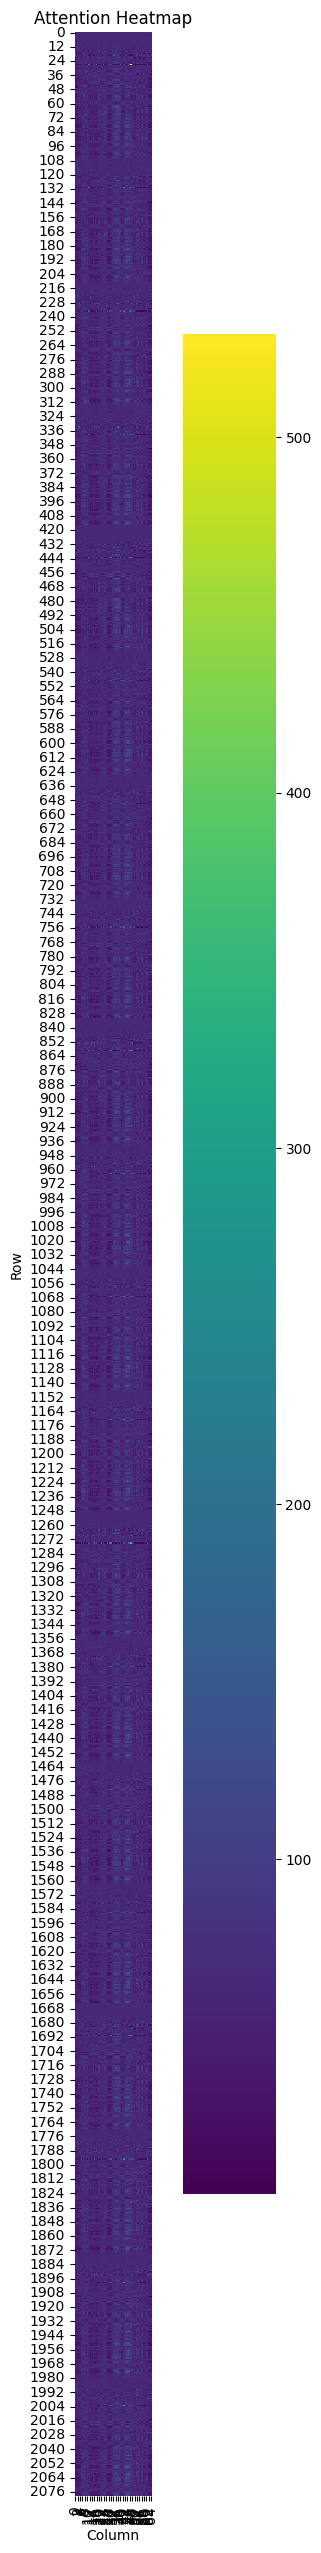

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

h = 3

heatmap = attention_spectrum[:, h, :]

# Example visualization of per residue attention for each of the 2080 (n, 4, n, n) attention files looking at head h
plt.figure(figsize=(8, 32))
ax = sns.heatmap(np.array(heatmap), cmap='viridis', cbar=True, square=True)

plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Attention Heatmap')
plt.show()